<a href="https://colab.research.google.com/github/mihir1125/machine-learning/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TODO
# [ ] Fix gradient descent
# [ ] Shuffled variant

import numpy as np
import tensorflow as tf
from math import ceil, floor
from itertools import accumulate
import copy

import matplotlib.pyplot as plt

In [11]:
#@title Helper Functions

def get_pieces(n, k):
    piece = n // k
    remainder = n % k
    arr = np.full((k,), piece)
    arr[:remainder] += np.ones(remainder, dtype=np.int64)
    return arr

def load_data(size = 120, *, shuffle = False):
    SIZE_pos = (int)(size / 2)
    SIZE_neg = size - SIZE_pos
    rng = np.random.default_rng(1234) # Seed
    X_train_pos = rng.uniform(
        low = -1.0,
        high = 1.0,
        size = (SIZE_pos, 2)
    )
    y_train_pos = np.ones(SIZE_pos, dtype=np.int64)

    # Get negative Y data
    # Apporximately equally distributed
    # for all 4 quadrants
    quadrants = ((1, 1), (-1, 1), (-1, -1), (1, -1))
    X_train_neg = rng.uniform(
        low = 1.0,
        high = 2.0,
        size = (SIZE_neg, 2)
    )

    zipped = zip(quadrants, accumulate(get_pieces(SIZE_neg, 4)))
    start = 0
    for quadrant, index in zipped:
        X_train_neg[start:index] *= quadrant
        start = index

    y_train_neg = np.zeros(SIZE_neg, dtype=np.int64)
    X_train = np.append(X_train_pos, X_train_neg, axis = 0)
    y_train = np.append(y_train_pos, y_train_neg, axis = 0)

    if shuffle:
        shuffled_indices = np.arange(size)
        rng.shuffle(shuffled_indices)
        X_train_shuffled = X_train[shuffled_indices]
        y_train_shuffled = y_train[shuffled_indices]
        return X_train_shuffled, y_train_shuffled

    return X_train, y_train

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

def compute_cost_logistic(X, y, w, b):
    m = X.shape[0] # No. of training examples
    f_wb = sigmoid(np.dot(X, w) + b)
    losses = -y * np.log(f_wb) - (1 - y) * np.log(1 - f_wb)
    loss = np.sum(losses) / m
    return loss

def compute_gradient_logistic(model_func, X, y, w, b):
    m, n = X.shape # No. of examples, features
    z = model_func(X, w, b)
    dJ_dw = np.zeros(n)
    dJ_db = 0
    ernz = np.exp(-z) # E Raised to Negative Z
    big_term_vector = (-y * ernz + (1 - y)) / (1 + ernz)

    dJ_db = np.sum(big_term_vector)
    for j in range(n):
        dJ_dw[j] = np.sum(w[j] * X[:, j] * big_term_vector)

    dJ_dw /= m
    dJ_db /= m
    return dJ_dw, dJ_db

def compute_gradient_logistic_traditional(X, y, w, b):
    m, n = X.shape
    dJ_dw = np.zeros((n,))
    dJ_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w) + b)
        err_i = f_wb_i - y[i]
        # err_i = y[i] - f_wb_i
        for j in range(n):
            dJ_dw[j] += err_i * X[i, j]
        dJ_db += err_i
    dJ_dw = dJ_dw/m
    dJ_db = dJ_db/m
    return dJ_dw, dJ_db


def gradient_descent_logistic(model_func, X, y, w_init, b_init, alpha, iter_count):
    w = w_init.copy()
    b = b_init
    J_history = []
    for i in range(iter_count):
        dJ_dw, dJ_db = compute_gradient_logistic(model_func, X, y, w, b)
        w = w - alpha * dJ_dw
        b = b - alpha * dJ_db

        if i < 100_000:
            loss = compute_cost_logistic(model_func, X, y, w, b)
            J_history.append(loss)
        if i % ceil(iter_count / 10) == 0:
            print(f"Iteration {i}: w: {w}, b: {b}, dJ_dw: {dJ_dw}, dJ_db: {dJ_db} Loss: {J_history[-1]}")
    return w, b, J_history

def gradient_descent_logistic_traditional(X, y, w_in, b_in, alpha, iter_count, *, verbose = False):
    J_history = []
    w = copy.deepcopy(w_in)
    b = b_in
    for i in range(iter_count):
        dJ_dw, dJ_db = compute_gradient_logistic_traditional(X, y, w, b)
        w = w - alpha * dJ_dw
        b = b - alpha * dJ_db

        if i < 100_000:
            J_history.append(compute_cost_logistic(X, y, w, b))

        if verbose and i % ceil(iter_count / 10) == 0:
            print(f"Iteration {i}: w: {w}, b: {b}, dJ_dw: {dJ_dw}, dJ_db: {dJ_db} Loss: {J_history[-1]}")

    return w, b, J_history

### Unshuffled

X_train_pos: (100, 2), y_train_pos: (100,)
X_train_neg: (100, 2), y_train_neg: (100,)


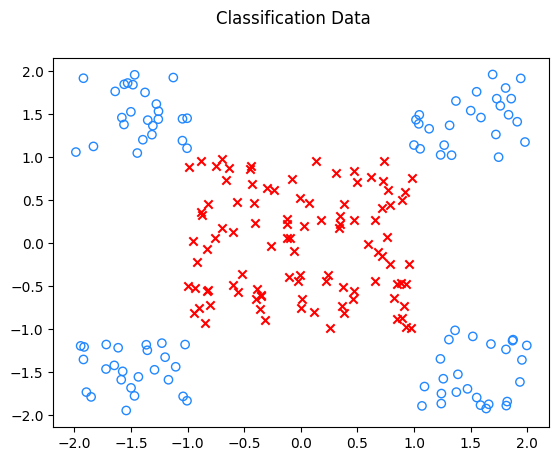

In [3]:
# Load data, unshuffled
X_train, y_train = load_data(200)

positive_indices = y_train == 1.
negative_indices = y_train == 0.

X_train_pos = X_train[positive_indices]
y_train_pos = y_train[positive_indices]
X_train_neg = X_train[negative_indices]
y_train_neg = y_train[negative_indices]

# Visualize
print(f"X_train_pos: {X_train_pos.shape}, y_train_pos: {y_train_pos.shape}")
print(f"X_train_neg: {X_train_neg.shape}, y_train_neg: {y_train_neg.shape}")
## Positives
fig, ax = plt.subplots()
ax.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], marker='x', c='red')
ax.scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], facecolors='none', edgecolors='#2288FF')
fig.suptitle("Classification Data")
plt.show()

In [10]:
m, n = X_train.shape
w_init = np.ones(n)
b_init = 1.
# alphas = (1.0e-3, 3.0e-3, 1.0e-4, 3.0e-4) # Attempt 1
# Attempt 1 conclusion: 3e-3 < alpha < 1e-4
# alphas = np.linspace(3.0e-3, 1.0e-4, num=4) # Attempt 2
# Attempt 2 conclusion: 3.0e-3 < alpha < 2.0e-3
alphas = np.linspace(2.0e-3, 1.1e-4, num=4) # Attempt 3
# Attempt 3 conclusion: 1.7e-3 < alpha < 1.9e-3
# alphas = np.linspace(1.7e-3, 1.9e-3, num=4)
iterations = 10_000

ws, bs, histories = [], [], []
for i in range(len(alphas)):
    w, b, J_history = gradient_descent_logistic_traditional(
        X = X_train,
        y = y_train,
        w_in = w_init,
        b_in = b_init,
        alpha = alphas[i],
        iter_count = iterations)

    ws.append(w)
    bs.append(b)
    histories.append(J_history)

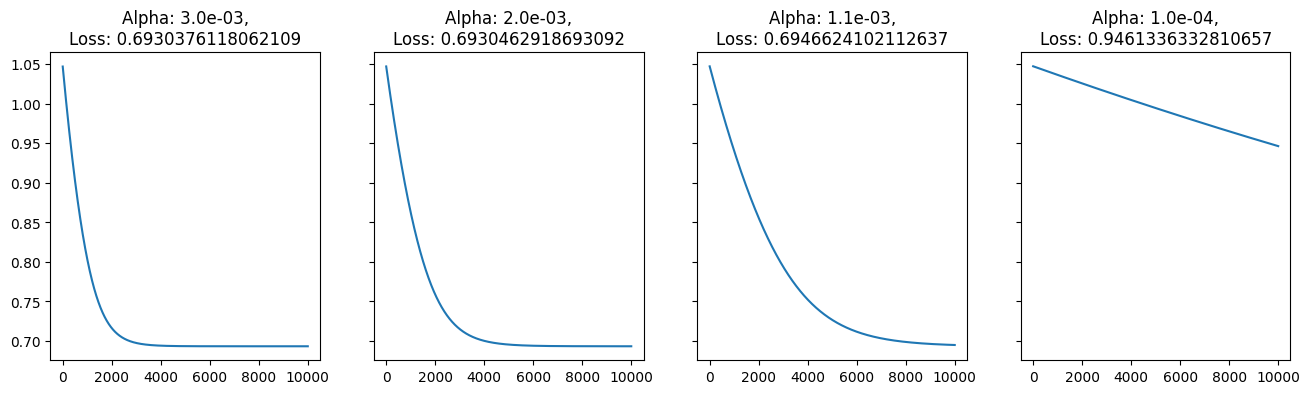

In [8]:
fix, axes = plt.subplots(
    1, len(alphas),
    figsize=(4*len(alphas), 4),
    sharey = True)

for i in range(len(alphas)):
    axes[i].plot(histories[i])
    axes[i].title.set_text(f"Alpha: {alphas[i]:.1e},\nLoss: {histories[i][-1]}")

plt.show()

166


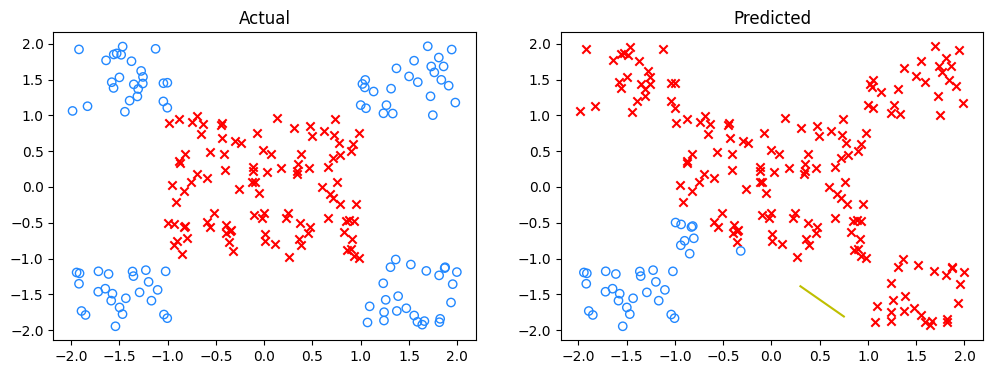

In [6]:
w_best = ws[3]
b_best = bs[3]

yhats = np.round(sigmoid(np.dot(X_train, w_best) + b_best))
yhats_pos = yhats == 1
yhats_neg = yhats == 0
print(len(yhats[yhats_pos]))

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(X_train_pos[:, 0], X_train_pos[:, 1], c='r', marker='x')
ax[0].scatter(X_train_neg[:, 0], X_train_neg[:, 1], marker='o', facecolors='none', edgecolors='#2288FF')
ax[0].title.set_text("Actual")
ax[1].scatter(X_train[yhats_pos][:, 0], X_train[yhats_pos][:, 1], c='r', marker='x')
ax[1].scatter(X_train[yhats_neg][:, 0], X_train[yhats_neg][:, 1], marker='o', facecolors='none', edgecolors='#2288FF')
ax[1].title.set_text("Predicted")

# Decision boundary

x_plot = np.linspace(0.3, 0.75, 5)
y_plot = (-b_best - w_best[0]*x_plot)/w_best[1]
ax[1].plot(x_plot, y_plot, c='y')

plt.show()